<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Playground/pg01/playground_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 초기화 소스

In [3]:
!pip install torchinfo

In [4]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [6]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

## 데이터 로드 소스 from torchVision

In [9]:
trainset = torchvision.datasets.Imagenette(root='./data', split='train', download=True, transform=hyperparams['transform'])
testset = torchvision.datasets.Imagenette(root='./data', split='val', download=True, transform=hyperparams['transform'])

trainloader_2 = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader_2 = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# trainloader_2 = torch.utils.data.DataLoader(ds_split['train'], batch_size=32, shuffle=True)
# testloader_2 = torch.utils.data.DataLoader(ds_split['test'], batch_size=32, shuffle=False)
# validationloader_2 = torch.utils.data.DataLoader(ds_split['validation'], batch_size=32, shuffle=False)

## 이진 분류된 이미지의 결과를 확인

In [ ]:
# def show_multiple_images_binary_label(dataset, n_images=9):
#     dataiter = iter(dataset)
#     images, labels = next(dataiter)
#     fig, axes = plt.subplots(3, 3, figsize=(6, 6))
#     axes = axes.flatten()

#     # OxfordIIITPet 데이터셋의 이진 레이블에 대한 이름을 정의합니다.
#     # 'binary-category'는 일반적으로 0:cat, 1:dog을 나타냅니다.
#     binary_labels_map = ['cat', 'dog']

#     for i in range(n_images):
#         ax = axes[i]
#         img = imshow(images[i])
#         ax.imshow(img)

#         # labels는 (binary_labels_batch_tensor, category_labels_batch_tensor) 형태이므로
#         # 첫 번째 텐서(binary_labels_batch_tensor)에서 i번째 항목을 가져옵니다.
#         binary_label_idx = labels[0][i].item()

#         # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
#         if 0 <= binary_label_idx < len(binary_labels_map):
#             label_text = binary_labels_map[binary_label_idx]
#         else:
#             label_text = f"Unknown (Index: {binary_label_idx})"

#         ax.set_title(f"Label: {label_text}")
#         ax.axis('off')

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # trainloader_2 에 대한 이진 레이블 시각화
# print("Trainloader_2 (Binary Labels):")
# show_multiple_images_binary_label(trainloader_2)

# # testloader_2 에 대한 이진 레이블 시각화
# print("\nTestloader_2 (Binary Labels):")
# show_multiple_images_binary_label(testloader_2)

# ResNet 구현체

## BasicBlock

In [10]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

## resnet 구현체

In [11]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## 다양한 resnet 생성

In [12]:
from torchvision import models
from torchinfo import summary

resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:02<00:00, 30.0MB/s]


21797672
21797672


## display_predictions_binary_label
예측된 라벨의 정확도 확인을 위해
예측라벨과 정답 라벨을 이미지와 함께 노출

* class_names = ['cat', 'dog']

In [ ]:
# def show_multiple_images_binary_label(dataset, n_images=9):
#     dataiter = iter(dataset)
#     images, labels = next(dataiter)
#     fig, axes = plt.subplots(3, 3, figsize=(6, 6))
#     axes = axes.flatten()

#     # OxfordIIITPet 데이터셋의 이진 레이블에 대한 이름을 정의합니다.

#     for i in range(n_images):
#         ax = axes[i]
#         img = imshow(images[i])
#         ax.imshow(img)

#         # labels는 (binary_labels_batch_tensor, category_labels_batch_tensor) 형태이므로
#         # 첫 번째 텐서(binary_labels_batch_tensor)에서 i번째 항목을 가져옵니다.

#         binary_label_idx = labels[0][i].item()

#         # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
#         if 0 <= binary_label_idx < len(binary_labels_map):
#             label_text = binary_labels_map[binary_label_idx]
#         else:
#             label_text = f"Unknown (Index: {binary_label_idx})"

#         ax.set_title(f"Label: {label_text}")
#         ax.axis('off')

#     plt.tight_layout()
#     plt.show()

# # 'binary-category'는 일반적으로 0:cat, 1:dog을 나타냅니다.
# binary_labels_map = ['cat', 'dog']
# def display_predictions_binary_label(loader, model, class_names, device, n_images=9):
#     dataiter = iter(loader)
#     images, labels = next(dataiter) # Get a batch of images and labels

#     fig, axes = plt.subplots(3, 3, figsize=(8, 8)) # Create a 3x3 grid for images
#     axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

#     with torch.no_grad(): # Disable gradient calculation for inference
#         for i in range(n_images):
#             if i >= len(images): # Ensure we don't go out of bounds if batch size is smaller than n_images
#                 break

#             ax = axes[i]
#             img = imshow(images[i]) # Use the helper function to properly display the image
#             ax.imshow(img)

#             # Get model output for the image
#             outputs = model(images[i].unsqueeze(0).to(device)) # Add batch dimension and move to device

#             # Get predicted class
#             _, predicted = torch.max(outputs.data, 1)

#             # Get the class names
#             predicted_class_name = class_names[predicted[0]]
#             # print(predicted_class_name)

#             binary_label_idx = labels[0][i].item()
#             # true_class_name = class_names[labels[i]]

#             # Set the title with true and predicted labels
#             # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
#             if 0 <= binary_label_idx < len(binary_labels_map):
#                 label_text = binary_labels_map[binary_label_idx]
#             else:
#                 label_text = f"Unknown (Index: {binary_label_idx})"

#             ax.set_title(f"True: {label_text}, Label: {predicted_class_name}")
#             # ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}", fontsize=10)
#             ax.axis('off') # Hide axes ticks

#     plt.tight_layout() # Adjust subplot parameters for a tight layout
#     plt.show() # Display the plot


# ResNet-34, ResNet-50 각각 plain모델과 residual모델

## PlainBlock 선언

In [ ]:
import torch
import torch.nn as nn

class PlainBlock(nn.Module):
    """
    ResNet의 BasicBlock과 구조는 같지만,
    Skip Connection(+ identity)이 없는 블록
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()

        # 첫 번째 Conv (Stride가 1이 아닐 수도 있음)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 Conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 1. Convolution 통과
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # [차이점] 여기서 ResNet은 'out += x'를 하지만, Plain 모델은 하지 않습니다.

        out = self.relu(out)
        return out


## Bulid Plainnet 선언

In [ ]:
def build_plainnet(is_50=False, input_shape=(32, 32, 3), num_classes=2):
    """
    ResNet-34와 동일한 층 수를 가지지만,
    Skip Connection이 없는 PlainNet-34 모델을 생성합니다.
    """

    # ResNet-34와 동일한 레이어 구성
    layers = [3, 4, 6, 3]

    # 블록 타입으로 BasicBlock 대신 PlainBlock을 사용
    # is_50(Bottleneck) 옵션은 PlainNet 실험에서 보통 34층 이하를 비교하므로 무시하거나 False로 둠
    model = ResNet(PlainBlock, layers, num_classes=num_classes)

    return model

## plainnet_34_2 수행

In [ ]:
plainnet_34_2 = build_plainnet(is_50=False, input_shape=(32, 32,3), num_classes=2)
print(summary(plainnet_34_2))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─PlainBlock: 2-5                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─PlainBlock: 2-6                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
│    └─PlainBlock: 2-7                   --
│    │    └─Conv2d: 3-11                 36,864

## plainnet_50_2

# 학습부

In [ ]:
BATCH_SIZE = 256
EPOCH = 10

In [ ]:

import time
import torch
import torch.nn as nn
import torch.optim as optim
def model_run_epoch_classnet(origin_model):
  # 1. 초기 설정
  current_time = time.time()
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = origin_model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

  optimizer = optim.SGD(origin_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

  origin_model_train_losses = []
  origin_model_val_accuracy = []

  print(f"Training on device: {device}")

  for epoch in range(EPOCH):
      resnet34.train()

      running_loss = 0.0      # 100 배치마다 출력용
      epoch_loss = 0.0        # 전체 Epoch 평균 계산용 (추가됨)
      correct = 0
      total = 0

      for i, (inputs, labels) in enumerate(trainloader_2, 0):
          # inputs: 이미지, labels: [binary_label, breed_label] 리스트
          # labels[0]이 Cat/Dog 이진 라벨입니다.
          inputs = inputs.to(device)
          targets = labels[0].to(device).long() # .long()은 정수형 변환 (필수)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

          # Loss 누적
          loss_val = loss.item()
          running_loss += loss_val
          epoch_loss += loss_val

          # 정확도 계산
          _, predicted = torch.max(outputs, 1)
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

          # 100 미니배치마다 로그 출력
          if i % 100 == 99:
              print(f"[{epoch + 1}, {i + 1:5d}] Step Loss: {running_loss / 100:.3f}")
              running_loss = 0.0 # 출력용 변수만 초기화

      # --- [수정 2] 정확한 Epoch Loss 계산 ---
      # running_loss는 중간에 0으로 초기화되므로, 별도의 epoch_loss 변수를 사용해야 정확합니다.
      avg_train_loss = epoch_loss / len(trainloader_2)
      train_acc = 100 * correct / total

      origin_model_train_losses.append(avg_train_loss)
      print(f"Epoch {epoch + 1} Finished. Avg Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

      # --- Validation Loop (검증) ---
      model.eval()
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for inputs, labels in testloader_2:
              inputs = inputs.to(device)
              targets = labels[0].to(device).long() # 검증 때도 labels[0] 사용

              outputs = model(inputs)
              _, predicted = torch.max(outputs, 1)

              val_total += targets.size(0)
              val_correct += (predicted == targets).sum().item()

      val_acc = 100 * val_correct / val_total
      origin_model_val_accuracy.append(val_acc)

      print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")
      print("-" * 20)

  print("Finished Training")
  print(f"Time elapsed: {time.time() - current_time:.2f} seconds")
  return origin_model_train_losses, origin_model_val_accuracy

# 트레이닝

In [ ]:
l34,a34 = model_run_epoch_classnet(resnet34)

In [ ]:
import matplotlib.pyplot as plt

def figure_2chart(title, l1,a1,l2,a2):

    # --- 데이터 준비 (예시 변수명입니다. 실제 저장한 변수명으로 교체하세요) ---
    # 예: epochs = range(1, 11)
    epochs = range(1, len(a1) + 1)

    # 1. 그래프 크기 설정
    plt.figure(figsize=(15, 6))

    # -------------------------------------------------------
    # [왼쪽 그래프] Validation Accuracy 비교
    # -------------------------------------------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, a1, 'b-o', label='Res'+title+' (Shortcut O)')
    plt.plot(epochs, a2, 'r--s', label='Plain'+title+' (Shortcut X)')

    plt.title('Validation Accuracy Comparison', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # -------------------------------------------------------
    # [오른쪽 그래프] Validation Loss 비교
    # (Loss 리스트가 있다면 이 부분을 주석 해제하고 사용하세요)
    # -------------------------------------------------------
    plt.subplot(1, 2, 2)

    plt.plot(epochs, l1, 'b-o', label='Res'+title+' Loss')
    plt.plot(epochs, l2, 'r--s', label='Plain'+title+' Loss')
    plt.title('Validation Loss Comparison', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
lp34,ap34 = model_run_epoch_classnet(plainnet_34_2)

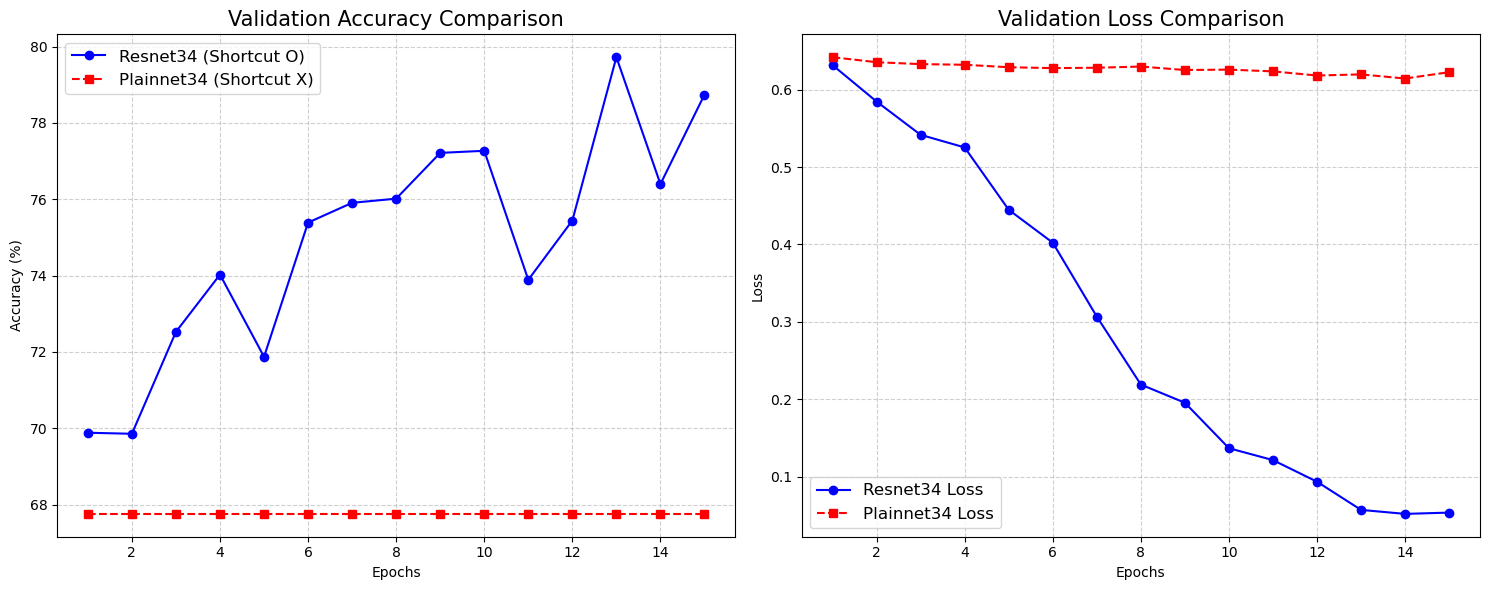

In [ ]:
figure_2chart("net34", l34,a34,lp34,ap34)

In [ ]:
# class_names = binary_labels_map
# display_predictions_binary_label(trainloader_2, resnet_34_2, class_names, device, n_images=9)